In [ ]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, '/media/pklein/SATA_SSD/GitHub/pypsa_utilities/eskom data/')
sys.path.insert(1, '/mnt/wsl/PHYSICALDRIVE0p1/GitHub/pypsa_utilities/eskom data/')

import data_utilities as du
import plotting_utilities as pu
import financial_utilities as fu
import xarray as xr
import cartopy.crs as ccrs
from pypsa.descriptors import get_switchable_as_dense as get_as_dense
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
from shapely.geometry import shape
import rioxarray
import atlite
import shapely

import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning) 


In [ ]:
colour_map={'onwind':'#77D1E4',
            'onwind_100MW':'#2eb8d6',
            'solar':'#FFBB4E',
            'solar_pv_1MW':'#FBDC81',
            'solar_pv_100MW':'#F99B00',
            'CSP':'#feed82',
            'battery':'#cba3cb',
            'bat_c':'#AA68AA',#CBA3CB
            'bat_d':'#AA68AA',
            'PHS':'#873f91',
            'phs_c':'#873f91',
            'phs_d':'#873f91',
            'coal':'#3C3C3C',
            'hydro':'#004F95',
            'ocgt':'#8D7867',
            'diesel':'#8D7867',
            'gas':'#8D7867',
            'OCGT':'#8D7867',
            'CCGT':'#ffa69e',
            'rmippp':'#51969B',
            'biomass':'#8C9A07',
            'nuclear':'#C84936',
            'demand_response':'#817E80',
            'loadshedding':'#DE9287'}

In [63]:
df = pd.read_excel('../data/digitized_system_eaf.xlsx',sheet_name=None,index_col=0)

In [62]:
df1 = pd.concat([df['CSIR-ambitions-2019'],pd.DataFrame(index=range(2019,2051),columns=['value'])],axis=0)['System EAF']
(0.88*df1.sort_index().interpolate()).to_clipboard()

In [ ]:

def generate_datetimeindex(start_date: str, end_date: str) -> pd.DatetimeIndex:
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    return pd.date_range(start_date, end_date, freq='1H')


# Generate the DatetimeIndex
idx = generate_datetimeindex('2009-01-01', '2021-12-31')

# Create a DataFrame with the DatetimeIndex
df = pd.DataFrame({'date': idx})

# Write the DataFrame to an Excel file
df.to_clipboard()


In [81]:
n0 = pypsa.Network('../networks/pre_CSIR-ambitions-2022_RSA_redz_lcopt_LC.nc')


INFO:pypsa.io:Imported network pre_CSIR-ambitions-2022_RSA_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, loads, storage_units
INFO:pypsa.io:Imported network pre_CSIR-ambitions-2022_RSA_redz_lcopt_LC_backup.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [91]:
n1 = pypsa.Network('../networks/pre_CSIR-ambitions-2022_RSA_redz_lcopt_LC (copy).nc')

INFO:pypsa.io:Imported network pre_CSIR-ambitions-2022_RSA_redz_lcopt_LC (copy).nc has buses, carriers, generators, global_constraints, loads, storage_units


<AxesSubplot: xlabel='period,timestep'>

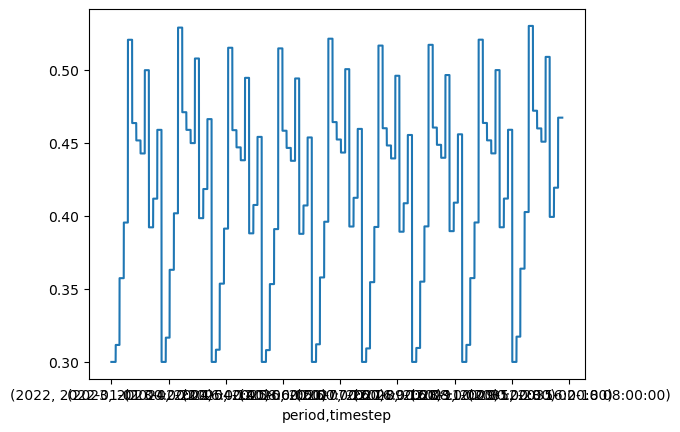

In [92]:
n1.generators_t.p_max_pu['Duvha'].plot()

<AxesSubplot: xlabel='period,timestep'>

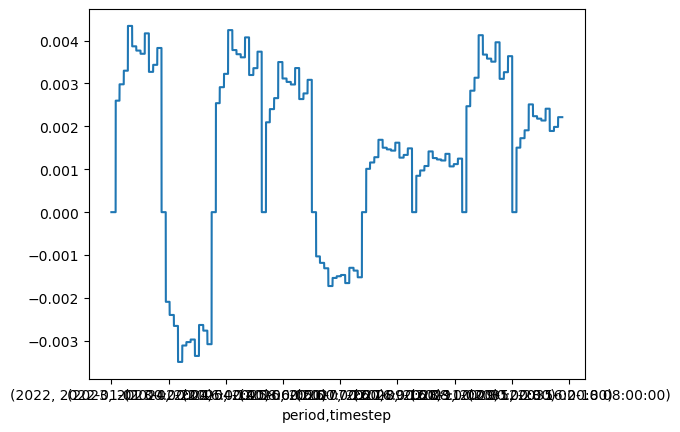

In [115]:
plant='Duvha'
(n0.generators_t.p_max_pu[plant]*16-n1.generators_t.p_max_pu[plant]).plot()

<AxesSubplot: xlabel='period,timestep'>

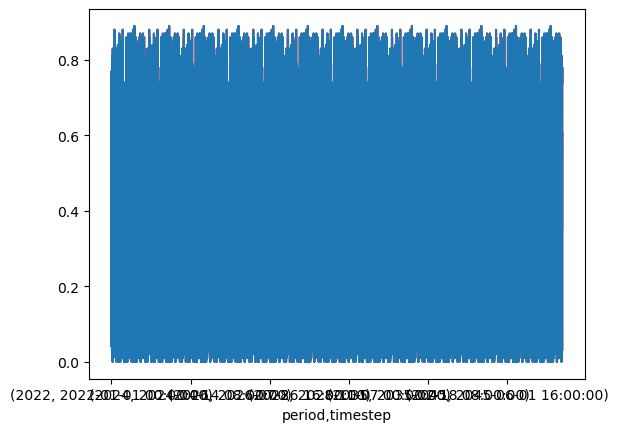

In [102]:
plant='RSA onwind_2025'
n0.generators_t.p_max_pu[plant].plot(color='r')
n1.generators_t.p_max_pu[plant].plot()

In [105]:
n0.generators_t.p_max_pu['Duvha']

period  timestep           
2022    2022-01-01 00:00:00    0.018750
        2022-01-01 01:00:00    0.018750
        2022-01-01 02:00:00    0.018750
        2022-01-01 03:00:00    0.018750
        2022-01-01 04:00:00    0.018750
                                 ...   
2050    2050-12-31 19:00:00    0.036861
        2050-12-31 20:00:00    0.036861
        2050-12-31 21:00:00    0.036861
        2050-12-31 22:00:00    0.036861
        2050-12-31 23:00:00    0.036861
Name: Duvha, Length: 113880, dtype: float64

In [116]:
n = pypsa.Network('../results/networks/solved_CSIR-ambitions-2022_RSA_redz_lcopt_LC.nc')

INFO:pypsa.io:Imported network solved_CSIR-ambitions-2022_RSA_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [ ]:
reserve_type='total'
carriers = ['battery','PHS']
carriers=['diesel','gas','OCGT','CCGT','battery','PHS'] 
y=2030
p_nom=n.generators.p_nom_opt[n.get_active_assets('Generator',y) & n.generators.carrier.isin(carriers)].sum()+n.storage_units.p_nom_opt[n.get_active_assets('StorageUnit',y)].sum()
(p_nom-n.generators_t.p.loc[y][n.generators.p_nom_opt[n.get_active_assets('Generator',y) & n.generators.carrier.isin(carriers)].index].sum(axis=1)-n.storage_units_t.p_dispatch.loc[y].sum(axis=1)).min()

In [117]:
capacity=pd.DataFrame(np.nan,index=np.append(n.generators.carrier.unique(),n.storage_units.carrier.unique()),columns=range(n.investment_periods[0],n.investment_periods[-1]+1))       
carriers=n.generators.carrier.unique()
carriers = carriers[carriers !='load_shedding']
for y in n.investment_periods:
    capacity.loc[carriers,y]=n.generators.p_nom_opt[(n.get_active_assets('Generator',y))].groupby(n.generators.carrier).sum()

carriers=n.storage_units.carrier.unique()
for y in n.investment_periods:
    capacity.loc[carriers,y]=n.storage_units.p_nom_opt[(n.get_active_assets('StorageUnit',y))].groupby(n.storage_units.carrier).sum()


In [118]:
capacity=capacity.T.interpolate().T

In [119]:
capacity=capacity.reindex(['nuclear','coal','CCGT','OCGT','diesel','gas','hydro','PHS','biomass','CSP','onwind','solar','battery'])

In [120]:
capacity

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
nuclear,1854.026627,1854.026627,1854.026627,1854.026627,1854.026627,1854.026627,1854.026627,1854.026627,1854.026627,1854.026627,...,1483.226627,1112.426627,741.626627,370.826627,0.026627,0.026627,0.026627,0.026627,0.026627,0.026627
coal,36636.379115,35710.199092,34784.019069,33857.839046,32931.659023,32005.479000,31108.814211,30212.149423,29315.484634,28418.819845,...,22600.308823,21417.805571,20235.302319,19052.799066,17870.295814,17503.914533,17137.533251,16771.151969,16404.770687,16038.389405
CCGT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OCGT,5543.633935,5544.370989,5545.108042,5545.845096,5546.582149,5547.319203,5845.030699,6142.742195,6440.453691,6738.165187,...,12959.774899,14023.583736,15087.392572,16151.201409,17215.010245,17729.688587,18244.366928,18759.045270,19273.723611,19788.401953
diesel,3072.000000,3072.000000,3072.000000,3072.000000,3072.000000,3072.000000,3072.000000,3072.000000,3072.000000,3072.000000,...,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
gas,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,...,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
hydro,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,...,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000
PHS,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,...,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000
biomass,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,...,193.060000,193.060000,193.060000,193.060000,193.060000,188.248000,183.436000,178.624000,173.812000,169.000000
CSP,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,570.000000,540.000000,510.000000,480.000000,450.000000,400.000000,350.000000,300.000000,250.000000,200.000000


(0.0, 200.0)

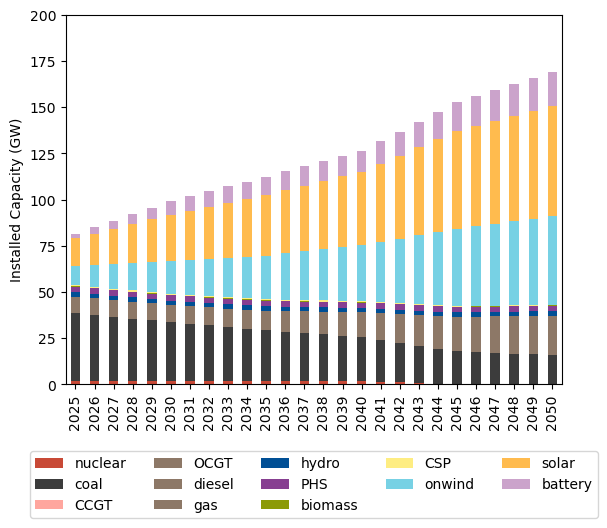

In [121]:
(capacity/1000).T.plot.bar(stacked=True,color=colour_map)
plt.legend(ncol=5,bbox_to_anchor =(0.5,-0.38), loc='lower center')
plt.ylabel('Installed Capacity (GW)')
plt.xlabel("")
plt.ylim([0,200])

In [ ]:
capacity.sum()

In [ ]:
n.plot(line_widths=1,
       bus_sizes=0)

In [73]:
n.loads_t.p_set.groupby(n.snapshots.get_level_values(0)).sum()

Load,RSA
period,
2022,2.455365e+08
2025,2.571553e+08
2030,2.769605e+08
2035,2.941598e+08
2040,3.113591e+08
2045,3.285584e+08
2050,3.457576e+08


In [70]:
n.generators_t.p['RSA load_shedding'].groupby(n.generators_t.p.index.get_level_values(0)).sum()/1e6

period
2022    0.014566
2025    0.015292
2030    0.011443
2035    0.009126
2040    0.009816
2045    0.010352
2050    0.009658
Name: RSA load_shedding, dtype: float64

In [ ]:
years=n.generators_t.p.index.get_level_values(0)
n.generators_t.p[n.generators[n.generators.carrier.isin(['diesel'])].index].sum(axis=1).groupby(years).sum()/(3056*8760)

In [ ]:
n.storage_units.p_nom_opt

In [ ]:
n.storage_units_t.state_of_charge['Drakensberg'].plot()

In [ ]:
n.global_constraints[n.global_constraints['sense']=='<=']

In [ ]:
eskom_data=du.eskom_data('../data/ESK2791.csv')

In [ ]:
eskom_data['other_re_installed'].groupby(eskom_data.index.year).max().to_clipboard()

In [ ]:
eskom_data['loadshed_mlr'].groupby(eskom_data.index.year).sum().to_clipboard()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 


for y in [2017,2018,2019,2020,2021,2022]:
    data=df.loc['Generation Total','PCLF %']
    plt.plot(data[data.index.year==y].values)



In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0)

In [ ]:
stations

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0).unique()
eaf=pd.DataFrame(0,index=stations,columns=range(2017,2023))
planned=pd.DataFrame(0,index=stations,columns=range(2017,2023))
unplanned=pd.DataFrame(0,index=stations,columns=range(2017,2023))
for s in stations:
    eaf.loc[s,:]=df.loc[s,'EAF %'].groupby(df.loc[s,'EAF %'].index.year).mean()
    planned.loc[s,:]=df.loc[s,'PCLF %'].groupby(df.loc[s,'PCLF %'].index.year).mean()
    unplanned.loc[s,:]=df.loc[s,'UCLF %'].groupby(df.loc[s,'UCLF %'].index.year).mean()+df.loc[s,'OCLF %'].groupby(df.loc[s,'OCLF %'].index.year).mean()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
df=df[df.type=='coal']
df.index=df.index.get_level_values(1)
variable='EAF %'
type_avg=df.groupby(level=0).mean()
type_avg.drop(['MW','capacity'],axis=1)
type_avg.loc[:,variable].groupby(type_avg.index.year).mean()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0)

installed_capacity=pd.DataFrame(0,index=stations,columns=range(2017,2023))
for s in stations:
    for y in range(2017,2023):
        installed_capacity.loc[s,y]=df.loc[(s,str(y)),'MW'].mean()

In [ ]:
installed_capacity.to_clipboard()

In [ ]:
mean_pclf=type_avg[variable].groupby(type_avg.index.month).mean().to_clipboard()
for y in [2017,2018,2019,2020,2021,2022]:
    plt.plot(type_avg.loc[str(y),variable].values)

plt.plot(mean_pclf.values,'k--',linewidth=3)
plt.legend([2017,2018,2019,2020,2021,2022])

In [ ]:
mean_pclf=coal_plants['UCLF %'].groupby(coal_plants.index.month).mean()
for y in [2017,2018,2019,2020,2021,2022]:
    plt.plot(coal_plants.loc[str(y),'UCLF %'].values)

plt.plot(mean_pclf.values,'k--',linewidth=3)
plt.legend([2017,2018,2019,2020,2021,2022])

In [ ]:
plt.plot(eskom_data['coal_eaf'])
plt.plot(df[df.type=='coal'].groupby('Date').sum()['capacity'].divide(df[df.type=='coal'].groupby('Date').sum()['MW']))
plt.ylabel('Coal fleet EAF')

In [ ]:
n365 = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC.nc')
n365.generators.p_nom_opt[(n365.get_active_assets('Generator',2040)) & (n365.generators.carrier=='onwind')].plot.bar()

In [ ]:
n350 = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-350p.nc')
n350.generators.p_nom_opt[(n350.get_active_assets('Generator',2040)) & (n350.generators.carrier=='onwind')].plot.bar()

In [ ]:
n = pypsa.Network('../results/version-0.6/networks/solved_IRP-2019_RSA_redz_lcopt_LC.nc')

In [ ]:
n[25] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-25p.nc')
n[10] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-10p.nc')
n[5] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-5p.nc')

In [ ]:
#s={}
#s[1200] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-1200SEG.nc')
#s[2400] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-2400SEG.nc')
s[3600] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-3600SEG.nc')

In [ ]:
n={}
n[365] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC.nc')
n[350] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-350p.nc')
n[300] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-300p.nc')
n[250] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-250p.nc')
n[200] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-200p.nc')
n[150] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-150p.nc')
n[100] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-100p.nc')
n[50] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-50p.nc')
n[25] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-25p.nc')
n[10] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-10p.nc')
n[50] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-5p.nc')

In [ ]:
n.investment_period_weightings

In [ ]:
n.generators.p_nom_opt[n.get_active_assets('Generator',2025)].groupby(n.generators.carrier).sum()

In [ ]:
n.generators.p_nom_opt[n.generators.carrier=='coal']

In [ ]:
n.generators.p_nom_opt[n.generators.carrier=='solar']

In [ ]:
nodes=[5,10,25,50,100,150,200,250,300,350,365]
capacity = pd.DataFrame(0,index=n[365].generators.carrier.unique(),columns=nodes)
for node in nodes:
    p_nom_opt = n[node].generators.p_nom_opt.groupby(n365.generators.carrier).sum()
    for tech in n365.generators.carrier:
        capacity.loc[tech,node] = p_nom_opt[tech]


In [ ]:
capacity = pd.DataFrame(0,index=n[365].generators.carrier,columns=nodes)

In [ ]:
capacity.T.plot.area()

In [ ]:
supply_regions = gpd.read_file(snakemake.input.supply_regions).buffer(-0.005) #.to_crs(n.crs)
resarea = gpd.read_file(snakemake.input.resarea).to_crs(supply_regions.crs)

In [ ]:
fig, ax = plt.subplots(figsize=[7, 7], subplot_kw={"projection": ccrs.PlateCarree()})
n.plot(ax=ax, boundaries=[14, 34, -35, -22])

In [ ]:
n.plot(ax=ax)

In [ ]:
n.lines[['bus0','bus1','num_parallel','length','s_nom_min']]

In [ ]:
n.lines['s_nom_opt']-n.lines['s_nom_min']

In [ ]:
n.generators.p_nom_opt.groupby(n.generators.carrier).sum()

In [ ]:
n.storage_units.p_nom_opt.groupby(n.storage_units.carrier=='battery').sum()

In [ ]:
n.generators_t.p_max_pu['RSA onwind_2040'].mean()

In [ ]:
n.generators_t.p['RSA onwind_2040'].mean()/n.generators.p_nom_opt['RSA onwind_2040']

In [ ]:
co2_emi = (n.generators_t.p.sum()/n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions)).sum()
co2_emi/1e6

In [ ]:
n.investment_period_weightings

In [ ]:
n.generators_t.p_max_pu.plot()

In [ ]:
# Find the column name and index for all values equal to 5
df = n.vars['Generator']['pnl']['p']
value = 468128
mask = df.eq(value)
result = mask.where(mask).stack()
print(result)
